# Multichannel Nonstatic Experiment Results

In [1]:
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import statsmodels.stats.api as sms

from db import conn

/u3/z3tu/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
%matplotlib inline

In [3]:
sns.set_style("whitegrid")

In [16]:
cursor = conn.cursor()
experiment_rows = [r for r in cursor.execute("""
    select g.name, args, dev_metric, test_metric from experiments e
    join experiment_groups g on e.group_id=g.gid
    where g.name=?""", ('mpcnn-lite-multichannel',))]

In [23]:
experiment_results = {
    'trecqa': [],
    'wikiqa': [],
    'sick': []
}

for row in experiment_rows:
    args = json.loads(row[1])
    dev_metrics = json.loads(row[2])
    test_metrics = json.loads(row[3])
    dataset = args['dataset']
    
    if args['arch'] not in ('mpcnn_lite_multichannel'):
        continue
    
    if 'multichannel' in args:
        arch = 'Multichannel'
    else:
        arch = 'Static'
    
    res_base = {
        'arch': arch,
        'dataset': dataset,
        'seed': args['seed']
    }
    
    results = []
    
    if dataset in ('trecqa', 'wikiqa'):
        results.append({**res_base, **{'split': 'dev', 'metric_name': 'MAP', 'metric_val': dev_metrics['map']}})
        results.append({**res_base, **{'split': 'dev', 'metric_name': 'MRR', 'metric_val': dev_metrics['mrr']}})
        results.append({**res_base, **{'split': 'test', 'metric_name': 'MAP', 'metric_val': test_metrics['map']}})
        results.append({**res_base, **{'split': 'test', 'metric_name': 'MRR', 'metric_val': test_metrics['mrr']}})
    elif dataset == 'sick':
        results.append({**res_base, **{'split': 'dev', 'metric_name': 'pearson', 'metric_val': dev_metrics['pearson']}})
        results.append({**res_base, **{'split': 'dev', 'metric_name': 'spearman', 'metric_val': dev_metrics['spearman']}})
        results.append({**res_base, **{'split': 'test', 'metric_name': 'pearson', 'metric_val': test_metrics['pearson']}})
        results.append({**res_base, **{'split': 'test', 'metric_name': 'spearman', 'metric_val': test_metrics['spearman']}})
    
    experiment_results[dataset].extend(results)

In [24]:
trecqa = pd.DataFrame(experiment_results['trecqa'])
wikiqa = pd.DataFrame(experiment_results['wikiqa'])
sick = pd.DataFrame(experiment_results['sick'])

In [25]:
experiment_rows[0]

('mpcnn-lite-multichannel',
 '{"program": "python", "main": "/u/z3tu/castorini/MP-CNN-Variants/main.py", "arg2": "/u/z3tu/castorini/MP-CNN-Variants/saved_models/arch_mpcnn_lite_multichannel_dataset_trecqa_seed_242879_multichannel", "arch": "mpcnn_lite_multichannel", "dataset": "trecqa", "epochs": 5, "device": 2, "lr": 0.00026, "regularization": 2.18e-05, "dropout": 0, "eps": 1e-08, "seed": 242879, "multichannel": 1}',
 '{"cross_entropy_loss": 0.8576247694242609, "map": 0.7624, "mrr": 0.853}',
 '{"cross_entropy_loss": 0.7453735827903641, "map": 0.7534, "mrr": 0.8184}')

In [27]:
trecqa['arch'].unique()

array(['Multichannel', 'Static'], dtype=object)

In [28]:
archs = ['Multichannel', 'Static']
def compare_change_to_baseline(df, metric):
    config_ids = df['seed'].unique()
    for arch in archs:
        diffs = []
        for config_id in config_ids:
            baseline = df[(df['seed'] == config_id) & (df['arch'] == 'Static')].iloc[0]['metric_val']
            conf_perf = df[(df['seed'] == config_id) & (df['arch'] == arch)].iloc[0]['metric_val']
            diffs.append(conf_perf - baseline)

        print(f'Architecture: {arch}')
        print(f'Median of {metric} change compared with single baseline: {np.median(diffs):.4f}')
        print(f'Mean of {metric} change compared with single baseline: {np.mean(diffs):.4f}')

## TrecQA

In [29]:
trec_map_vs_archs_test = trecqa[(trecqa['metric_name'] == 'MAP') & (trecqa['split'] == 'test')]
trec_mrr_vs_archs_test = trecqa[(trecqa['metric_name'] == 'MRR') & (trecqa['split'] == 'test')]
trec_map_vs_archs_dev = trecqa[(trecqa['metric_name'] == 'MAP') & (trecqa['split'] == 'dev')]
trec_mrr_vs_archs_dev = trecqa[(trecqa['metric_name'] == 'MRR') & (trecqa['split'] == 'dev')]

In [30]:
for arch in trec_map_vs_archs_test['arch'].unique():
    arr = trec_map_vs_archs_test[trec_map_vs_archs_test['arch'] == arch]['metric_val']
    ci = sms.DescrStatsW(arr).tconfint_mean()
    print(f'{arch}: ({ci[0]:.4f}, {ci[1]:.4f})')

Multichannel: (0.7492, 0.7912)
Static: (0.7508, 0.7879)


In [31]:
for arch in trec_mrr_vs_archs_test['arch'].unique():
    arr = trec_mrr_vs_archs_test[trec_mrr_vs_archs_test['arch'] == arch]['metric_val']
    ci = sms.DescrStatsW(arr).tconfint_mean()
    print(f'{arch}: ({ci[0]:.4f}, {ci[1]:.4f})')

Multichannel: (0.8130, 0.8799)
Static: (0.8138, 0.8655)


In [32]:
trec_map_vs_archs_test.groupby('arch').mean()

,metric_val,seed
arch,,
Multichannel,0.77022,338248.8
Static,0.76932,338248.8


In [33]:
trec_mrr_vs_archs_test.groupby('arch').mean()

,metric_val,seed
arch,,
Multichannel,0.84644,338248.8
Static,0.83966,338248.8


In [34]:
trec_map_vs_archs_test.sort_values('seed')

,arch,dataset,metric_name,metric_val,seed,split
10,Static,trecqa,MAP,0.7477,57936,test
14,Multichannel,trecqa,MAP,0.7713,57936,test
26,Static,trecqa,MAP,0.7767,122119,test
30,Multichannel,trecqa,MAP,0.7584,122119,test
2,Multichannel,trecqa,MAP,0.7534,242879,test
6,Static,trecqa,MAP,0.7606,242879,test
34,Static,trecqa,MAP,0.7768,468471,test
38,Multichannel,trecqa,MAP,0.7710,468471,test
18,Static,trecqa,MAP,0.7848,799839,test
22,Multichannel,trecqa,MAP,0.7970,799839,test


In [35]:
compare_change_to_baseline(trec_map_vs_archs_test, 'MAP')

Architecture: Multichannel
Median of MAP change compared with single baseline: -0.0058
Mean of MAP change compared with single baseline: 0.0009
Architecture: Static
Median of MAP change compared with single baseline: 0.0000
Mean of MAP change compared with single baseline: 0.0000


In [36]:
compare_change_to_baseline(trec_mrr_vs_archs_test, 'MRR')

Architecture: Multichannel
Median of MRR change compared with single baseline: -0.0082
Mean of MRR change compared with single baseline: 0.0068
Architecture: Static
Median of MRR change compared with single baseline: 0.0000
Mean of MRR change compared with single baseline: 0.0000


## WikiQA

In [37]:
wikiqa_map_vs_archs_test = wikiqa[(wikiqa['metric_name'] == 'MAP') & (wikiqa['split'] == 'test')]
wikiqa_mrr_vs_archs_test = wikiqa[(wikiqa['metric_name'] == 'MRR') & (wikiqa['split'] == 'test')]
wikiqa_map_vs_archs_dev = wikiqa[(wikiqa['metric_name'] == 'MAP') & (wikiqa['split'] == 'dev')]
wikiqa_mrr_vs_archs_dev = wikiqa[(wikiqa['metric_name'] == 'MRR') & (wikiqa['split'] == 'dev')]

In [38]:
for arch in wikiqa_map_vs_archs_test['arch'].unique():
    arr = wikiqa_map_vs_archs_test[wikiqa_map_vs_archs_test['arch'] == arch]['metric_val']
    ci = sms.DescrStatsW(arr).tconfint_mean()
    print(f'{arch}: ({ci[0]:.4f}, {ci[1]:.4f})')

Static: (0.6085, 0.6882)
Multichannel: (0.6463, 0.7137)


In [39]:
for arch in wikiqa_mrr_vs_archs_test['arch'].unique():
    arr = wikiqa_mrr_vs_archs_test[wikiqa_mrr_vs_archs_test['arch'] == arch]['metric_val']
    ci = sms.DescrStatsW(arr).tconfint_mean()
    print(f'{arch}: ({ci[0]:.4f}, {ci[1]:.4f})')

Static: (0.6171, 0.7023)
Multichannel: (0.6573, 0.7283)


In [40]:
wikiqa_map_vs_archs_test.groupby('arch').mean()

,metric_val,seed
arch,,
Multichannel,0.67998,338248.8
Static,0.64838,338248.8


In [41]:
wikiqa_mrr_vs_archs_test.groupby('arch').mean()

,metric_val,seed
arch,,
Multichannel,0.69282,338248.8
Static,0.65968,338248.8


In [42]:
compare_change_to_baseline(wikiqa_map_vs_archs_test, 'MAP')

Architecture: Multichannel
Median of MAP change compared with single baseline: 0.0168
Mean of MAP change compared with single baseline: 0.0316
Architecture: Static
Median of MAP change compared with single baseline: 0.0000
Mean of MAP change compared with single baseline: 0.0000


In [43]:
compare_change_to_baseline(wikiqa_mrr_vs_archs_test, 'MRR')

Architecture: Multichannel
Median of MRR change compared with single baseline: 0.0226
Mean of MRR change compared with single baseline: 0.0331
Architecture: Static
Median of MRR change compared with single baseline: 0.0000
Mean of MRR change compared with single baseline: 0.0000


(array([ 0.55 ,  0.575,  0.6  ,  0.625,  0.65 ,  0.675,  0.7  ,  0.725,
         0.75 ,  0.775]), <a list of 10 Text yticklabel objects>)

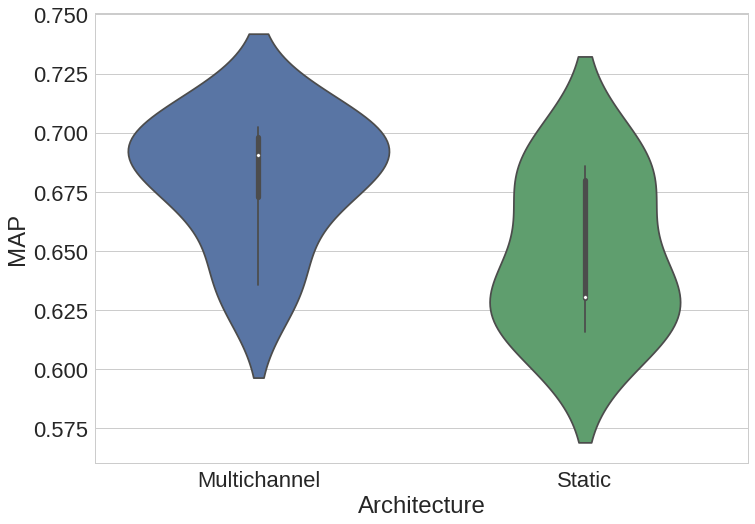

In [44]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
ax = sns.violinplot(x='arch', y='metric_val', data=wikiqa_map_vs_archs_test, order=archs, ax=ax)
plt.xlabel('Architecture', fontsize=24)
plt.ylabel('MAP', fontsize=24)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
# plt.ylim(0.6, 0.75)

## SICK

In [45]:
sick_pearson_vs_archs_test = sick[(sick['metric_name'] == 'pearson') & (sick['split'] == 'test')]
sick_spearman_vs_archs_test = sick[(sick['metric_name'] == 'spearman') & (sick['split'] == 'test')]
sick_pearson_vs_archs_dev = sick[(sick['metric_name'] == 'pearson') & (sick['split'] == 'dev')]
sick_spearman_vs_archs_dev = sick[(sick['metric_name'] == 'spearman') & (sick['split'] == 'dev')]

In [46]:
for arch in sick_pearson_vs_archs_test['arch'].unique():
    arr = sick_pearson_vs_archs_test[sick_pearson_vs_archs_test['arch'] == arch]['metric_val']
    ci = sms.DescrStatsW(arr).tconfint_mean()
    print(f'{arch}: ({ci[0]:.4f}, {ci[1]:.4f})')

Static: (0.8553, 0.8698)
Multichannel: (0.8598, 0.8678)


In [47]:
for arch in sick_spearman_vs_archs_test['arch'].unique():
    arr = sick_spearman_vs_archs_test[sick_spearman_vs_archs_test['arch'] == arch]['metric_val']
    ci = sms.DescrStatsW(arr).tconfint_mean()
    print(f'{arch}: ({ci[0]:.4f}, {ci[1]:.4f})')

Static: (0.7892, 0.8046)
Multichannel: (0.7945, 0.8033)


In [48]:
sick_pearson_vs_archs_test.groupby('arch').mean()

,metric_val,seed
arch,,
Multichannel,0.863798,338248.8
Static,0.862553,338248.8


In [49]:
sick_spearman_vs_archs_test.groupby('arch').mean()

,metric_val,seed
arch,,
Multichannel,0.798925,338248.8
Static,0.796896,338248.8


In [50]:
compare_change_to_baseline(sick_pearson_vs_archs_test, 'pearson')

Architecture: Multichannel
Median of pearson change compared with single baseline: 0.0014
Mean of pearson change compared with single baseline: 0.0012
Architecture: Static
Median of pearson change compared with single baseline: 0.0000
Mean of pearson change compared with single baseline: 0.0000


In [51]:
compare_change_to_baseline(sick_spearman_vs_archs_test, 'spearman')

Architecture: Multichannel
Median of spearman change compared with single baseline: 0.0009
Mean of spearman change compared with single baseline: 0.0020
Architecture: Static
Median of spearman change compared with single baseline: 0.0000
Mean of spearman change compared with single baseline: 0.0000


(array([ 0.845,  0.85 ,  0.855,  0.86 ,  0.865,  0.87 ,  0.875,  0.88 ,
         0.885]), <a list of 9 Text yticklabel objects>)

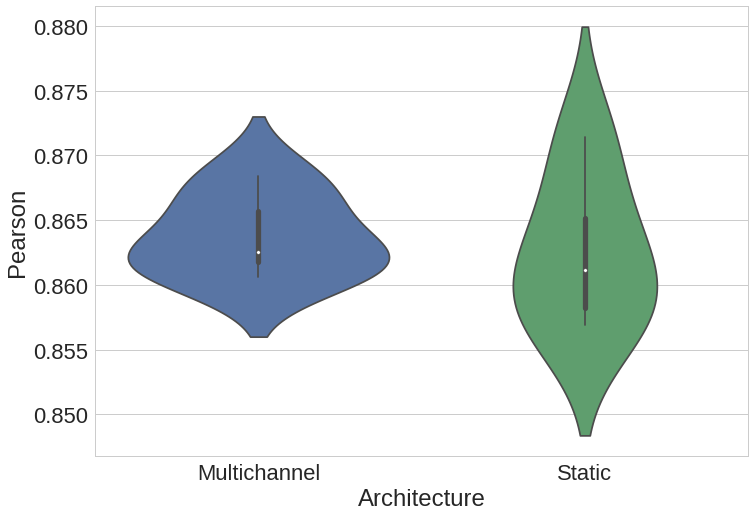

In [52]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
ax = sns.violinplot(x='arch', y='metric_val', data=sick_pearson_vs_archs_test, order=archs, ax=ax)
plt.xlabel('Architecture', fontsize=24)
plt.ylabel('Pearson', fontsize=24)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
# plt.ylim(0.86, 0.88)

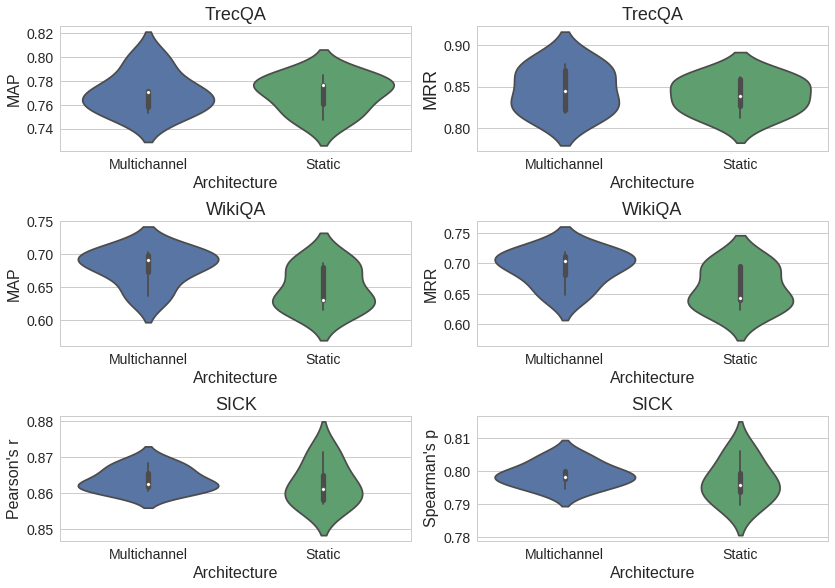

In [53]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
title_size = 18
axis_size = 16
tick_size = 14

ax = plt.subplot(321)
sns.violinplot(x='arch', y='metric_val', data=trec_map_vs_archs_test, order=archs, ax=ax)
plt.ylabel('MAP', fontsize=axis_size)
plt.xlabel('Architecture', fontsize=axis_size)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.title('TrecQA', fontsize=title_size)

ax = plt.subplot(322)
sns.violinplot(x='arch', y='metric_val', data=trec_mrr_vs_archs_test, order=archs, ax=ax)
plt.ylabel('MRR', fontsize=18)
plt.xlabel('Architecture', fontsize=axis_size)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.title('TrecQA', fontsize=title_size)

ax = plt.subplot(323)
sns.violinplot(x='arch', y='metric_val', data=wikiqa_map_vs_archs_test, order=archs, ax=ax)
plt.ylabel('MAP', fontsize=axis_size)
plt.xlabel('Architecture', fontsize=axis_size)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.title('WikiQA', fontsize=title_size)

ax = plt.subplot(324)
sns.violinplot(x='arch', y='metric_val', data=wikiqa_mrr_vs_archs_test, order=archs, ax=ax)
plt.ylabel('MRR', fontsize=axis_size)
plt.xlabel('Architecture', fontsize=axis_size)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.title('WikiQA', fontsize=title_size)

ax = plt.subplot(325)
sns.violinplot(x='arch', y='metric_val', data=sick_pearson_vs_archs_test, order=archs, ax=ax)
plt.ylabel("Pearson's r", fontsize=axis_size)
plt.xlabel('Architecture', fontsize=axis_size)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.title('SICK', fontsize=title_size)

ax = plt.subplot(326)
sns.violinplot(x='arch', y='metric_val', data=sick_spearman_vs_archs_test, order=archs, ax=ax)
plt.ylabel("Spearman's p", fontsize=axis_size)
plt.xlabel('Architecture', fontsize=axis_size)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.title('SICK', fontsize=title_size)
plt.tight_layout()